<a href="https://colab.research.google.com/github/onticonti/SEO_Python/blob/master/Serp_Ranking_elbise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
!pip install requests[security]
import string
import urllib
import collections
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk import word_tokenize, pos_tag, pos_tag_sents
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
stop = stopwords.words('english')
%matplotlib inline
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import itertools as it
import networkx as nx
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
! pip install pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis.sklearn
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import time
from time import sleep
#headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}

     |████████████████████████████████| 2.6MB 2.8MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.6MB 2.6MB/s 
     |████████████████████████████████| 552kB 16.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=e896c3cf1c2d98376e75e04465e4c9d40489da06826cb1fb5d5de79b4e202555
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=00ccbc32fd9c4ca58fcf2b7475ecbfdf8b7c1dd63e9a87b9ad003a71222914bc
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [9]:
base_url = "https://www.google.com.tr/search"
queries = ["elbise", "abiye", "elbise kirala"]
serp_queries = []
serp_urls = []
clean_links = []
links = []
serp_titles = []
serp_descriptions = []

for q in queries:
    query = urllib.parse.quote_plus(q)
    serp_queries.append(query)

for q in serp_queries:
    url = "{base_url}?q={query}&num={num}&cr={serp_country}".format(base_url=base_url, query=q, num="10", serp_country="GB")
    serp_urls.append(url)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    result_div = soup.find_all('div', attrs = {'class': 'ZINbbc'})
    for r in result_div:
        # Checks if each element is present, else, raise exception
        try:
            link = r.find('a', href = True)
            title = r.find('div', attrs={'class':'vvjwJb'}).get_text()
            description = r.find('div', attrs={'class':'s3v9rd'}).get_text()
            # Check to make sure everything is present before appending
            if link != '' and title != '' and description != '': 
                links.append(link['href'])
                serp_titles.append(title)
                serp_descriptions.append(description)
        # Next loop if one element is not present
        except:
            continue
    to_remove = []
    for i, l in enumerate(links):
        clean = re.search('\/url\?q\=(.*)\&sa',l)

        # Anything that doesn't fit the above pattern will be removed
        if clean is None:
            to_remove.append(i)
            continue
        clean_links.append(clean.group(1))
        #print(clean_links)

dedupe_clean_links = list(dict.fromkeys(clean_links))

In [10]:
paragraphs = []
titles = []
scraped_content = []
scraped_titles = []
for url in dedupe_clean_links:
        #time.sleep(0.01)
        response = requests.get(url, time.sleep(2)) #headers=headers
        soup2 = BeautifulSoup(response.content, "html.parser")
        paragraphs = soup2.find_all('p')
        titles = soup2.find_all(re.compile('^h[1-4]$'))
               
        for paragraph in paragraphs:
            paragraphs = [paragraph.text]
            paragraphs = paragraph.get_text()
            scraped_content.append(paragraphs)
        
        for title in titles:
            titles = [title.text]
            titles = title.get_text()
            scraped_titles.append(titles)
scraped_content = list(map(str.strip, scraped_content))
scraped_titles = list(map(str.strip, scraped_titles))

In [12]:
def count_tags(input_tag):
    tag_count = {}
    for word, tag in input_tag:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return(tag_count)

df = pd.DataFrame.from_dict({'Serp_Content': scraped_content}).astype(str)
df['Serp_Content'] = df['Serp_Content'].fillna("").str.lower().str.replace('[^\w\s]','')
df['Serp_Content'] = df['Serp_Content'].apply(lambda x: [item for item in x.split() if item not in stop]).map(pos_tag)
df['Serp_Content_PoS_Counts'] = df['Serp_Content'].map(count_tags)
df.head()
df.to_csv("serp.csv",encoding="utf8")

In [13]:
vocabulary = {}
for row in df['Serp_Content']:
    for word, tag in row:
        if word in vocabulary:
            if tag in vocabulary[word]:
                vocabulary[word][tag] += 1
            else:
                vocabulary[word][tag] = 1
        else:
            vocabulary[word] = {tag: 1}

vocabulary_df = pd.DataFrame.from_dict(vocabulary, orient='index')
vocabulary_df.fillna(value=0, inplace=True)

vocabulary_df.rename(columns = {'NN':'Noun'},inplace=True)
vocabulary_df.rename(columns = {'NNS':'Noun'},inplace=True)
vocabulary_df.rename(columns = {'NNP':'Noun'},inplace=True)
vocabulary_df.rename(columns = {'NNPS':'Noun'},inplace=True)
vocabulary_df.rename(columns = {'RB':'Adverb'},inplace=True)
vocabulary_df.rename(columns = {'RBR':'Adverb'},inplace=True)
vocabulary_df.rename(columns = {'RBS':'Adverb'},inplace=True)
vocabulary_df.rename(columns = {'VB':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBD':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBG':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBG':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBN':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBP':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBZ':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'JJ':'Adjective'},inplace=True)
vocabulary_df.rename(columns = {'JJR':'Adjective'},inplace=True)
vocabulary_df.rename(columns = {'JJS':'Adjective'},inplace=True)

pos_list = ['Noun', 'Adverb', 'Verb', 'Adjective']

vocabulary_df = vocabulary_df[pos_list]
vocabulary_df = vocabulary_df.groupby(lambda x:x, axis=1).sum()
vocabulary_df = vocabulary_df.sort_values('Noun', ascending=False)

vocabulary_df.head()

,Adjective,Adverb,Noun,Verb
elbise,1.0,3.0,282.0,12.0
abiye,18.0,0.0,164.0,19.0
elbiseler,3.0,3.0,122.0,4.0
bir,3.0,0.0,116.0,1.0
ile,15.0,0.0,100.0,0.0


Text(0.5, 0, 'Count')

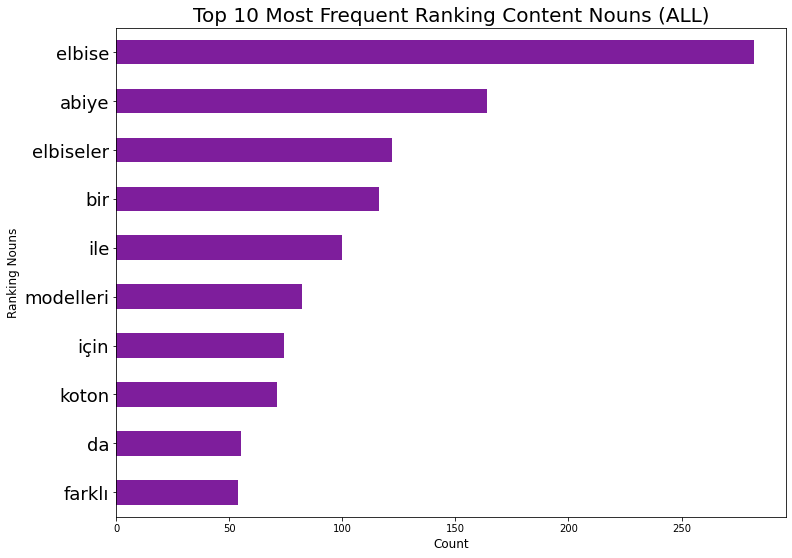

In [14]:
size4 = 10 # Change this number to how many words you want to show in your visual
tag4 = 'Noun' # Change this to the PoS tag that you want to analyse 
ax = vocabulary_df[tag4].sort_values().tail(size4).plot(kind='barh', figsize=(12,9), color='xkcd:purple')
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Top 10 Most Frequent Ranking Content Nouns (ALL)', fontsize='20')
ax.set_ylabel('Ranking Nouns', fontsize='12')
ax.set_xlabel('Count', fontsize='12')
#ax.title.set_position([.5, 1.01])

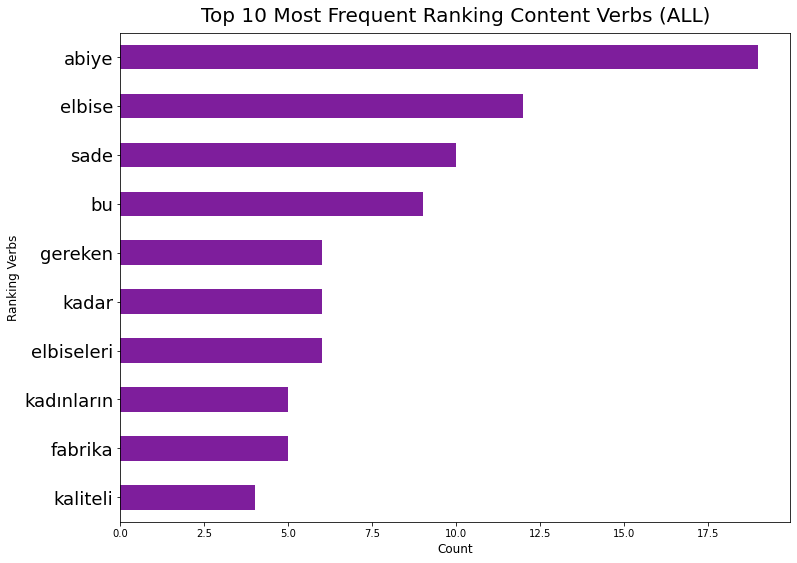

In [15]:
size5 = 10 # Change this number to how many words you want to show in your visual
tag5 = 'Verb' # Change this to the PoS tag that you want to analyse 
ax = vocabulary_df[tag5].sort_values().tail(size5).plot(kind='barh', figsize=(12,9), color='xkcd:purple')
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Top 10 Most Frequent Ranking Content Verbs (ALL)', fontsize='20')
ax.set_ylabel('Ranking Verbs', fontsize='12')
ax.set_xlabel('Count', fontsize='12')
ax.title.set_position([.5, 1.01])

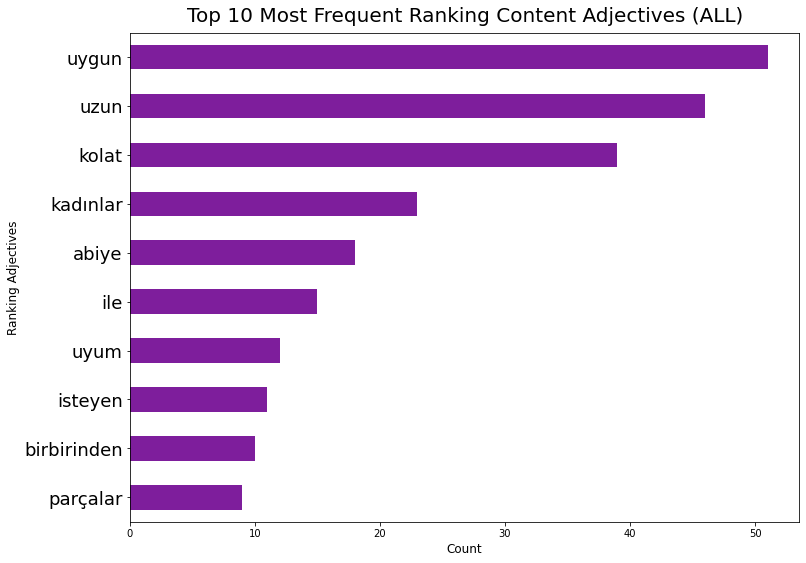

In [16]:
size6 = 10 # Change this number to how many words you want to show in your visual
tag6 = 'Adjective' # Change this to the PoS tag that you want to analyse 
ax = vocabulary_df[tag6].sort_values().tail(size6).plot(kind='barh', figsize=(12,9), color='xkcd:purple')
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Top 10 Most Frequent Ranking Content Adjectives (ALL)', fontsize='20')
ax.set_ylabel('Ranking Adjectives', fontsize='12')
ax.set_xlabel('Count', fontsize='12')
ax.title.set_position([.5, 1.01])

In [17]:
scraped_content_2 = scraped_content.copy()
scraped_content_3 = ''.join(map(str, scraped_content_2))
scraped_content_3 = scraped_content_3.strip(string.punctuation)
scraped_content_3 = scraped_content_3.replace(",", " ").replace("[", " ").replace("]", " ").replace("\\", " ")
entities = nlp(scraped_content_3)
labels = [x.label_ for x in entities.ents]
entity_map = dict([(str(x), x.label_) for x in nlp(str(entities)).ents])

#entity_map
#displacy.render(nlp(str(entities)), jupyter=True, style='ent')

def count_entities(input_tag):
    tag_count = {}
    for word, tag in input_tag:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return(tag_count)

df2 = pd.DataFrame.from_dict({'Serp_Content': scraped_content})
df2['Serp_Content'] = df2['Serp_Content'].astype(str).str.replace('[^\w\s]','')
def spacy_entity(df):    
    df2 = nlp(df)
    df3 = [[w.text,w.label_] for w in df2.ents]
    return df3
df2['Serp_Content'] = df2['Serp_Content'].apply(spacy_entity)
df2['Entity_Counts'] = df2['Serp_Content'].map(count_entities)

ent_vocabulary = {}
for row in df2['Serp_Content']:
    for word, tag in row:
        if word in ent_vocabulary:
            if tag in ent_vocabulary[word]:
                ent_vocabulary[word][tag] += 1
            else:
                ent_vocabulary[word][tag] = 1
        else:
            ent_vocabulary[word] = {tag: 1}

ent_df = pd.DataFrame.from_dict(ent_vocabulary, orient='index')
ent_df.fillna(value=0, inplace=True)

ent_df.sort_values('ORG', ascending=False).head(10)

,ORG,PERSON,GPE,FAC,NORP,PRODUCT,DATE,QUANTITY,CARDINAL,ORDINAL,WORK_OF_ART,EVENT,LOC
Koton,47.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gece Elbiseleri,13.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Özel,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Üzeri,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
çıkan,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Farklı,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kumaş,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sosyal,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yeni,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Parola,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
for token, tag in df.Serp_Content[0]:
    if re.match(r'NN*|JJ*', tag):
        print (token, tag)

noun_phrases = [[token for token, tag in sent if re.match(r'NN*|JJ*', tag)] 
                for sent in df.Serp_Content]
edgelist = [edge for phrase in noun_phrases for edge in it.combinations(phrase, 2)]

G = nx.Graph(edgelist)
index = nx.betweenness_centrality(G)
for component in list(nx.connected_components(G)):
    if len(component)<5:
        for node in component:
            G.remove_node(node)

sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)

# Top 20 noun phrases by betweenness centrality:
#for word, centr in sorted_index[:20]:
        #print (word, centr)

remove = [node for node,degree in dict(G.degree()).items() if degree < 2]

#%pylab inline
#%config InlineBackend.figure_format = 'png'
#plt.rc('figure', figsize=(24, 18))
#G.remove_nodes_from([n for n in index if index[n] == .0])
#G.remove_nodes_from(remove)
#node_size = [index[n]*20000 for n in G]
#pos = nx.spring_layout(G)
#nx.draw_networkx(G, pos, node_size=node_size, edge_color='Y', alpha=.8, linewidths=0, font_color='Black', font_size='10', font_weight='bold')

sezon NN
tarz NN
parçaları NN
ile NN
şık NNP
kombinler NN
yaratmanızı NN
koton NN
elbiseleri NN
gardırobunuzda NN
yerini NN
almayı NN
bekliyor NN
doğru NN
ayakkabı NN
çanta NNP
ile NN
rahatça NN
kombin NN
yapabileceğiz NN
kotonun NN
elbiseleri NN
mevsim NN
şıklık NNP
vadediyor NN
uzun JJ
kısa NN
elbiseler NN
pileli JJ
elbiseler NN
ya NN
da NN
sırt NN
dekolteli NN
uzanan JJ
koton NN
elbise NN
modeli NN
trendyolda NN
sizleri NN
bekliyor NN
pek NN
çok NNP
tarzda NN
zengin NN
elbise NN
modeli NN
koton NN
tarz NN
isteyen JJ
kadına NN
uygun JJ
fiyatlı NN
şık NNP
parçalar JJ
vadediyor NN
kadınların NN
günlük NN
giyim NN
ürünleri NNP
içinde NN
önemli NNP
bir NN
sahip JJ
olan JJ
elbiseler NN
tek NN
parça NN
olması NN
sebebi NN
ile NN
birçok NN
açıdan NN
rahatlık NN
sunuyor NN
elbiseler NN
günlük NN
yaşantıda NN
tercih NN
edildiği NN
gibi NN
nikah JJ
düğün NN
nişan NN
özel NNP
davetler NN
yıl NN
dönümleri NN
özel NNP
yemekler NN
gibi NN
önemli NNP
günlerin NN
olmazsa NN
olmaz NN
giyim NN
ürünler

In [19]:
resonance_df = pd.DataFrame(sorted_index, columns=['Word', 'Resonance'])

resonance_df.sort_values('Resonance', ascending=False).head()

,Word,Resonance
0,elbise,0.069508
1,için,0.045186
2,bir,0.044942
3,ile,0.039489
4,abiye,0.025278


In [20]:
scraped_titles_df = pd.DataFrame.from_dict({'Serp_Titles': scraped_titles}).astype(str)
scraped_titles_df['Serp_Titles'] = scraped_titles_df['Serp_Titles'].fillna("").str.lower().str.replace('[^\w\s]','').apply(lambda x: [item for item in x.split() if item not in stop])
scraped_titles_list = list(filter(None,scraped_titles_df.Serp_Titles.tolist()))
serp_titles_counts = collections.Counter(max_df = 0.90)

for phrase in scraped_titles_list:
    #serp_titles_counts.update(nltk.ngrams(phrase, 1))
    serp_titles_counts.update(nltk.ngrams(phrase, 2))
    serp_titles_counts.update(nltk.ngrams(phrase, 3))
serp_titles_trends=serp_titles_counts.most_common(50)

ranking_titles_trends=pd.DataFrame(serp_titles_trends, columns=["Titles", "Count"])

def remove_brackets(Titles):
    fixed_keyword=' '.join(Titles)
    return fixed_keyword

ranking_titles_trends['Titles'] = ranking_titles_trends.Titles.apply(remove_brackets)

ranking_titles_trends.head()

,Titles,Count
0,balik model,19
1,model abiye,19
2,balik model abiye,19
3,uzun abiye,18
4,kadin balik,17


In [23]:
topics_df = pd.DataFrame.from_dict({'Serp_Content': scraped_content}).astype(str)
data = topics_df.Serp_Content.values.tolist()
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuation

data_words = list(sent_to_words(data))

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                         # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                             max_df = 0.90
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
data_dense = data_vectorized.todense()

In [24]:
# Build LDA Model - can take a while!
lda_model = LatentDirichletAllocation(n_components=10,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}


In [26]:
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
Topics = ["Topic Label 1","Topic Label 2","Topic Label 3","Topic Label 4","Topic Label 5", "Topic Label 6", "Topic Label 7", "Topic Label 8", "Topic Label 9", "Topic Label 10"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords.head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Topics
Topic 0,icin,yor,abiye,sagl,sahip,vucut,mattox,elbiseler,bulunuyor,tasar,yaka,mevsim,gereken,iddial,son,papell,ozel,elbise,wear,parcalar,Topic Label 1
Topic 1,son,icin,trend,taray,explorer,internet,parti,parcalar,ideal,kan,ozel,yor,elbise,mattox,papell,abiye,wear,elbiseler,hold,farkl,Topic Label 2
Topic 2,icin,ince,elbiseler,tum,olan,elbise,gereken,sahip,mevsim,tasar,papell,mattox,ise,son,ideal,farkl,ask,vucut,parcalar,trend,Topic Label 3
Topic 3,volume,iddial,ise,dress,farkl,icin,abiye,sagl,yor,elbise,mattox,papell,ozel,wear,elbiseler,parcalar,hold,ince,trend,parti,Topic Label 4
Topic 4,rol,icin,ayakkab,abiye,ideal,urun,farkl,papell,yor,ise,sahip,elbiseler,mattox,ozel,elbise,wear,parcalar,hold,ince,trend,Topic Label 5


In [27]:
serp_dict = pd.DataFrame.from_dict({'SERP_Titles': serp_titles, 'SERP_Descriptions': serp_descriptions}).astype(str).drop_duplicates(subset=['SERP_Titles'], keep=False)
serp_dict["SERP_Combination"] = serp_dict["SERP_Titles"].map(str) + serp_dict["SERP_Descriptions"]
serp_dict["SERP_Combination"] = serp_dict["SERP_Combination"].fillna("").str.lower().str.replace('[^\w\s]','').apply(lambda x: [item for item in x.split() if item not in stop]).map(pos_tag)
serp_dict["SERP_Combination_Counts"] = serp_dict["SERP_Combination"].map(count_tags)
serp_language_vocabulary = {}
for row in serp_dict["SERP_Combination"]:
    for word, tag in row:
        if word in serp_language_vocabulary:
            if tag in serp_language_vocabulary[word]:
                serp_language_vocabulary[word][tag] += 1
            else:
                serp_language_vocabulary[word][tag] = 1
        else:
            serp_language_vocabulary[word] = {tag: 1}

serp_language_vocabulary_df = pd.DataFrame.from_dict(serp_language_vocabulary, orient='index')
serp_language_vocabulary_df.fillna(value=0, inplace=True)
serp_language_vocabulary_df.rename(columns = {'NN':'Noun'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'NNS':'Noun'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'NNP':'Noun'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'NNPS':'Noun'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'RB':'Adverb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'RBR':'Adverb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'RBS':'Adverb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VB':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBD':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBG':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBG':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBN':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBP':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBZ':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'JJ':'Adjective'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'JJR':'Adjective'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'JJS':'Adjective'},inplace=True)
serp_language_vocabulary_df = serp_language_vocabulary_df[pos_list]
serp_language_vocabulary_df = serp_language_vocabulary_df.groupby(lambda x:x, axis=1).sum()
serp_language_vocabulary_df = serp_language_vocabulary_df.sort_values('Noun', ascending=False)
serp_language_vocabulary_df.head()

,Adjective,Adverb,Noun,Verb
elbise,0.0,1.0,67.0,2.0
modelleri,1.0,0.0,33.0,0.0
abiye,10.0,0.0,27.0,5.0
elbiseleri,3.0,0.0,15.0,1.0
gece,0.0,0.0,15.0,2.0


In [28]:
scraped_content_string = ' '.join(str(e) for e in scraped_content)
scraped_title_string = ' '.join(str(e) for e in scraped_titles)
scraped_concat_string = scraped_content_string + scraped_title_string
question_extraction = re.compile(r'[A-Za-z][\w\s]+[?]')
question = question_extraction.findall(scraped_concat_string)
questions = []
questions.append(question)
question_df = pd.DataFrame(questions)
question_df = question_df.transpose()
question_df['totalwords'] = question_df[0].str.split().str.len()
question_df = question_df.drop(question_df[(question_df.totalwords < 4) | (question_df.totalwords > 10)].index)
question_df = question_df.rename(columns={0: 'Question', 'totalwords': 'Question_Word_Length'})
question_df = question_df.drop_duplicates(subset ="Question")
nlp = spacy.load('en', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)

def get_topic_labels(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(topic)

question_df["Topic_Grouping_Label"]= question_df['Question'].apply(apply_predict_topic)
question_df["Topic_Wordings"]= question_df['Question'].apply(get_topic_labels)
question_df = question_df.drop(columns=['Question_Word_Length'])
question_df.head(15)

,Question,Topic_Grouping_Label,Topic_Wordings
0,yelik Sözleşmesi Zaten üye misin?,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."
4,uygun fiyat seçeneği ile ulaşmaya ne dersiniz?,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."
6,Dar gelen abiye elbise nasıl genişletilir?,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."
9,Beni hatırla\n\n Giriş Yap Parolanızı mı unutt...,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."
11,Zeynep ve Kezziban öyle güzel bir iş yapıyorla...,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."
12,Bir giydiğinizi de bir daha giymiyorsunuz?,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."
13,Biz Showroom Exclusive Randevu Al İletişim Nas...,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."
16,Mekana Göre Mezuniyet Elbisesi Nasıl Seçilir?,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."
19,a Varan İndirim DressIstanbul Gece Elbiseleri ...,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."
20,ne Çıkan Tasarımlar Neden Dressistanbul?,Topic Label 1,"[yor, abiye, sagl, sahip, vucut, mattox, elbis..."


In [29]:
from google.colab import files
writer = pd.ExcelWriter('SERP_Research_Test.xlsx')
vocabulary_df.to_excel(writer, sheet_name='Ranking Vocabulary')
ent_df.sort_values('ORG', ascending=False).to_excel(writer, sheet_name='Ranking Entities')
resonance_df.to_excel(writer, sheet_name='Topical Resonance')
ranking_titles_trends.to_excel(writer, sheet_name='Title Co-Occurrence')
df_topic_keywords.to_excel(writer, sheet_name='Topic Modelling Groupings')
serp_language_vocabulary_df.to_excel(writer, sheet_name='Language Trends In SERPs')
question_df.to_excel(writer, sheet_name='Questions Answered')
writer.save()